In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import Caretaker
from pyfoomb import Visualization

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


# Modelling

In general, it is advised to write down the model before implementing is in code. In juypter notebooks, this can be nicely done using the TeX syntax.

### Sequential kinetic model

$$A \xrightarrow[]{k_1} B \xrightarrow[]{k_2} C$$

#### Derivatives
$$
\begin{align}
    \frac{dA}{dt} &= -k_1 \cdot A & A\left(t_0\right) = A_0\\
    \frac{dB}{dt} &= k_1 \cdot A - k_2 \cdot B & B\left(t_0\right) = B_0\\
    \frac{dC}{dt} &= k_2 \cdot B & C\left(t_0\right) = C_0\\
\end{align}
$$

#### Parametrization
$$
\begin{align}
    \mathbf{\theta_x} &= \left[ k_1 \; k_2\right]^T\\
    \mathbf{x}_0 &= \left[ A_0 \; B_0 \; C_0\right]^T\\
\end{align}
$$

# Implementation

Afterwards, the model class is created. this new class (here, `SequentialKinetic`) subclasses `BioprocessModel`. Thereby, the new class will inherit all relevant methods and properties needed to work with the model in the `pyFOOMB` package.

It is mandatory that the new class `SequentialKinetics` implements the method `rhs` (for right hand side), as seen below. This method describes the state derivatives, which are used by the integrator. In case the new class does not implement the method `rhs`, an error is raised.

There are two more methods that can be implemented by the new class in case one seeks to implement a model with events. These methods are `state_events` with signature `(self, t, y, sw)` and `change_states` with signature `(self, y, sw, state_event_info)`. When implementing a model with event, the signature of method `rhs` in needed to look like `(self, t, y, sw)`. How to work on models with events is shown in the seconds example notebook.

In [2]:
# Defines the model class
class SequentialKinetic(BioprocessModel):
    
    def rhs(self, t, y):
        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, C = y
        
        # Unpacks the model parameters.
        k1 = self.model_parameters['k1']
        k2 = self.model_parameters['k2']
        
        # Defines the derivatives.
        dAdt = -k1 * A
        dBdt = k1 * A - k2*B
        dCdt = k2*B
        
        # Returns the derivative as list (or numpy array).
        # The order corresponds to the state vector.
        return [dAdt, dBdt, dCdt]
    
    
# Defines a dictionary for the initial values.
# The keys corresponds to the model states, extended by a 0 (zero).
initial_values = {
    'A0' : 50.0,
    'B0' : 0.0,
    'C0' : 0.0,
}

# Defines a dictionary for the model parameters
# The keys match those variable names used in the model class
model_parameters = {
    'k1' : 0.2,
    'k2' : 0.1,
}

# The Caretaker

After defining a model class and corresponding dictionaries describing its parametrization, a `caretaker` object is creates from the `Caretaker` class, provided by the `pyFOOMB` package. The caretaker manages all the methods that are needed to work with your bioprocess model.

In [3]:
# Instantiate a Caretaker, which manages the model and its parametrization.
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

In [4]:
# Runs a forward simulation.
simulation = caretaker.simulate(t=24)

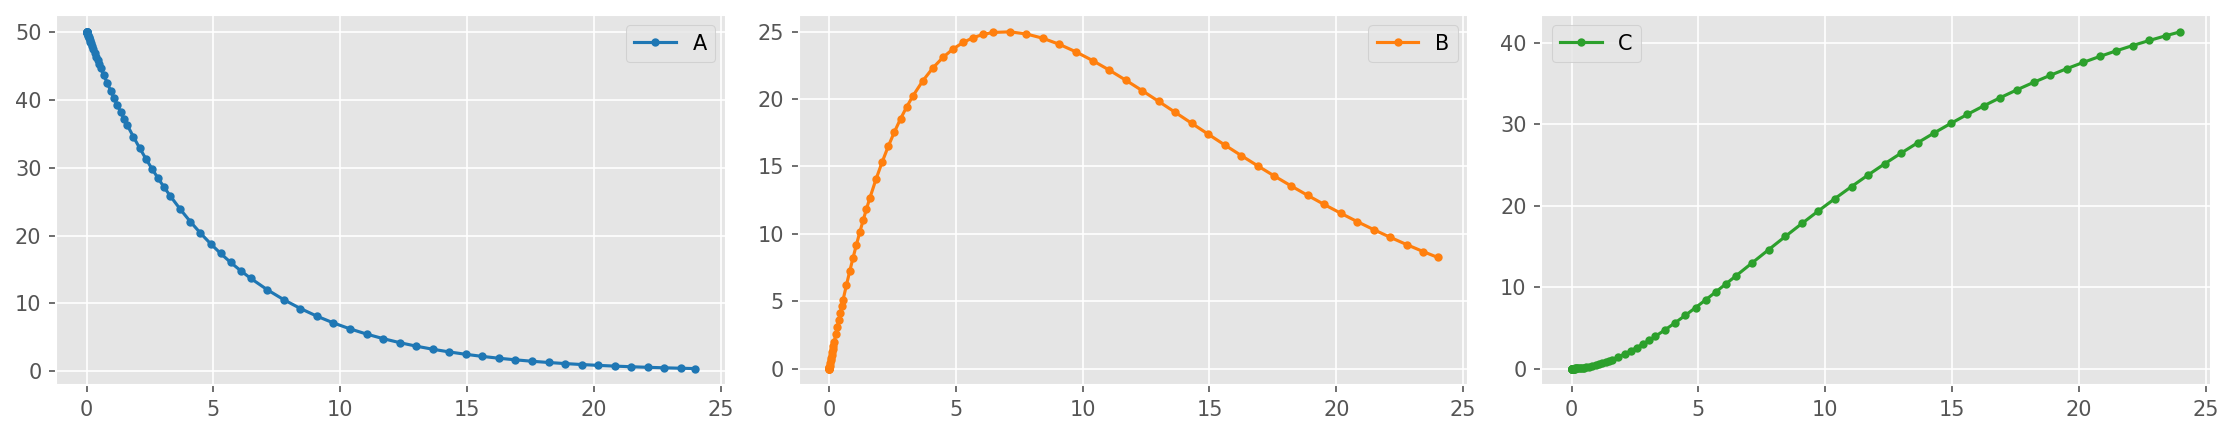

In [5]:
# Visualize the resulting trajectories
_ = Visualization.show_kinetic_data(simulation)

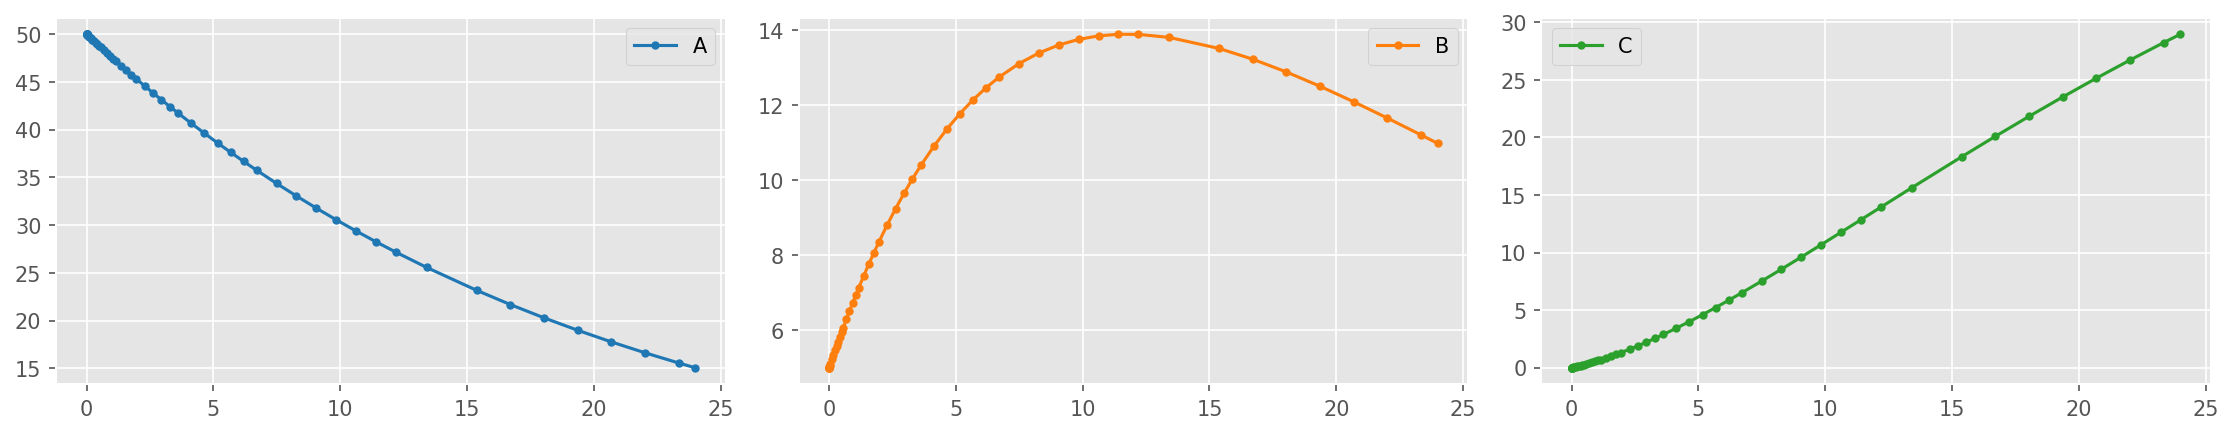

In [6]:
# One can run a forward simulation also for different, specific parameter values by using the `parameters` keyword.
simulation = caretaker.simulate(t=24, parameters={'B0' : 5.0, 'k1' : 0.05})
_ = Visualization.show_kinetic_data(simulation)

In [7]:
# This is easily verified by looking at the parameter mapping property of the caretaker
caretaker.parameter_mapping

,,local_name,value
global_name,replicate_id,,
A0,NaN,A0,50.0
B0,NaN,B0,0.0
C0,NaN,C0,0.0
k1,NaN,k1,0.2
k2,NaN,k2,0.1


# Model replicates

In this parameter mapping, there are entries named `global_name`, `replicate_id`, and `local_name`. This is because the Caretaker class can handle several replicates / instances of a model, which all share the same strukture. On the other hand it is allowed that certain variables can be share by a subset of the model replicates. This is indicated by the same `local_name`. The next section will show how to create such a caretaker and how to handle the multiple model replicates.

In [8]:
# We'll overwrite the current caretaker.
# Note the use of the keyword `replicate_ids`
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    replicate_ids=['1st', '2nd'], 
)

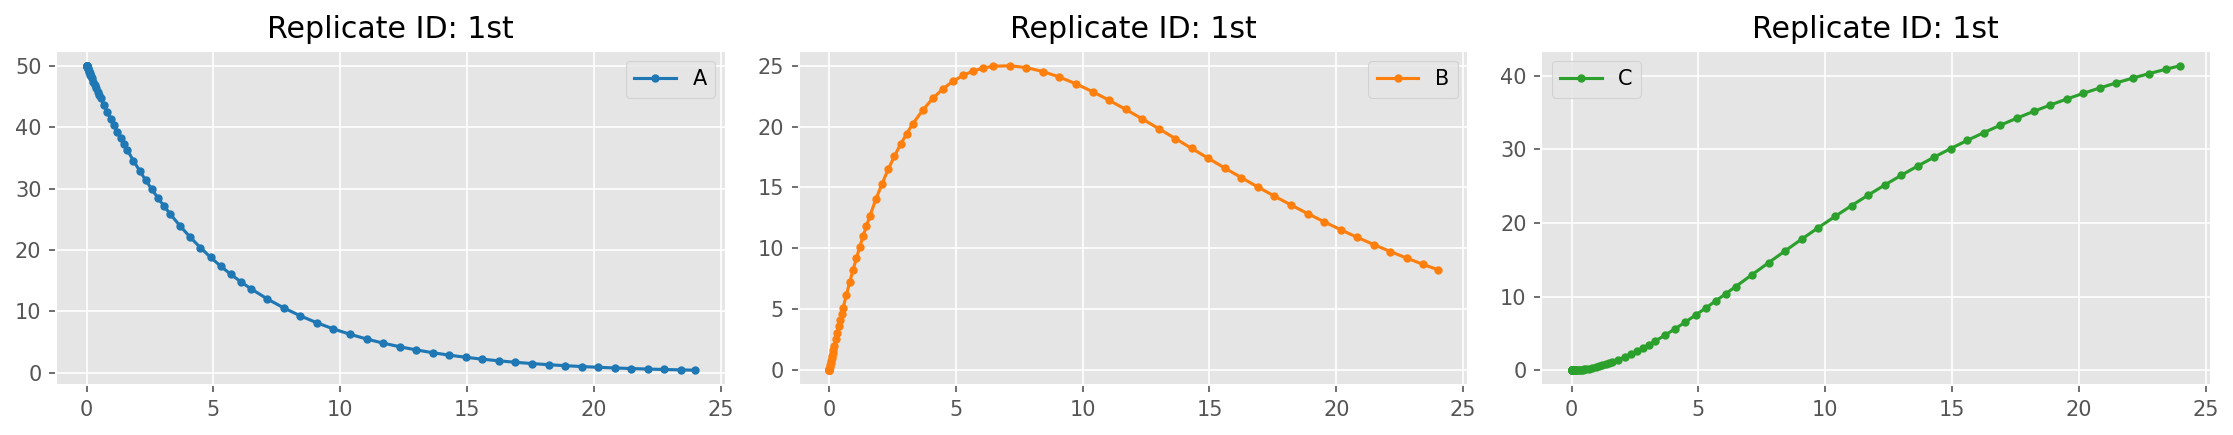

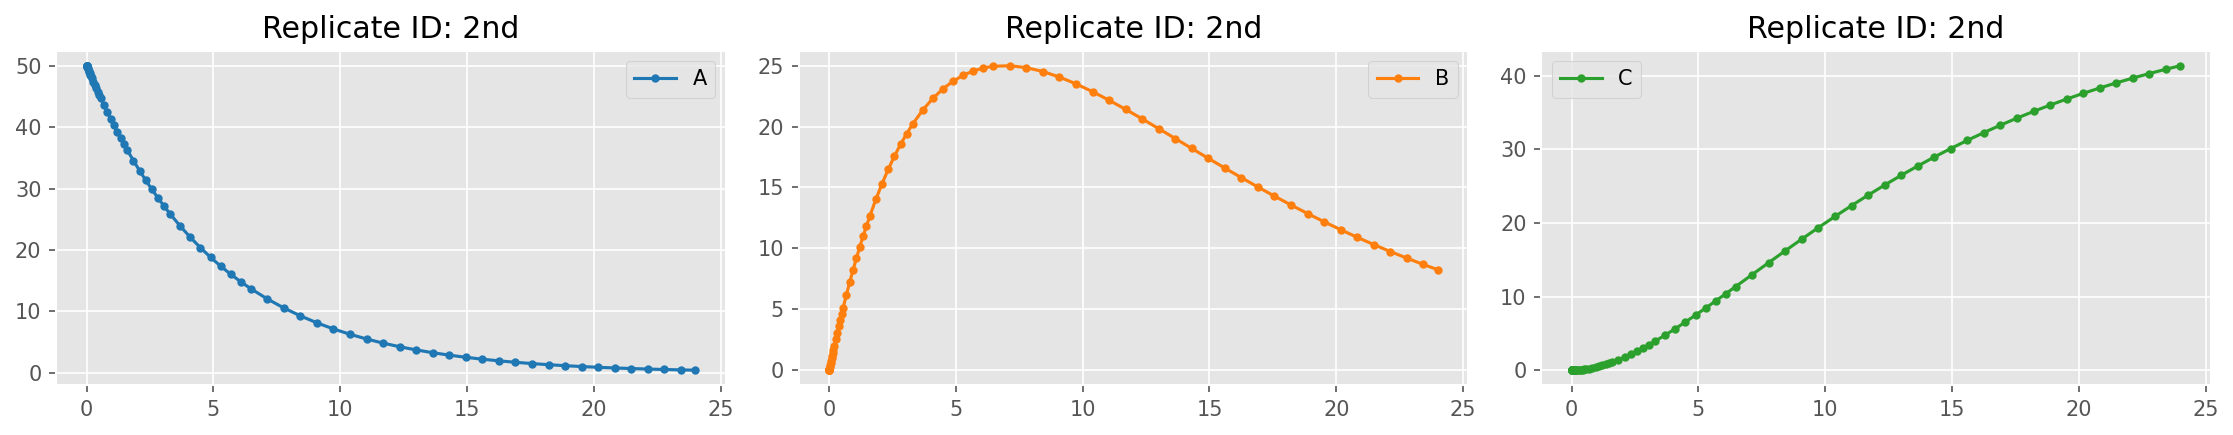

In [9]:
# Like before, runs a forward simulation and visualize the result
simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation)

We obtain the same trajectories for both replicate_ids. This is becuase they share all the same parameters by default.
To allow `replicate_id` specific parameter values, one need to apply parameter mappings.

In [10]:
from pyfoomb import ParameterMapper

In [11]:
# Creates a list of ParameterMapper objects that will be applied to the caretaker
# NOTE: One can use also just tuples with entries (replicate_id, global_id, local_name, value)
# NOTE: The `local_name` parameter can also be left empty. 
#       Then, the local parameter name will be constructed automatically from the `replicate_id` and `global_name`
mappings = [
    ParameterMapper(replicate_id='1st', global_name='A0', value=50.0),
    ParameterMapper(replicate_id='2nd', global_name='A0', value=25.0),
    ParameterMapper(replicate_id='2nd', global_name='B0', local_name='B0_second', value=5.0),
]

# Applies the mappings
caretaker.apply_mappings(mappings)

# Show the result
caretaker.parameter_mapping

local_name value
global_name replicate_id                 
A0          1st              A0_1st  50.0
            2nd              A0_2nd  25.0
B0          1st                  B0   0.0
            2nd           B0_second   5.0
C0          1st                  C0   0.0
            2nd                  C0   0.0
k1          1st                  k1   0.2
            2nd                  k1   0.2
k2          1st                  k2   0.1
            2nd                  k2   0.1

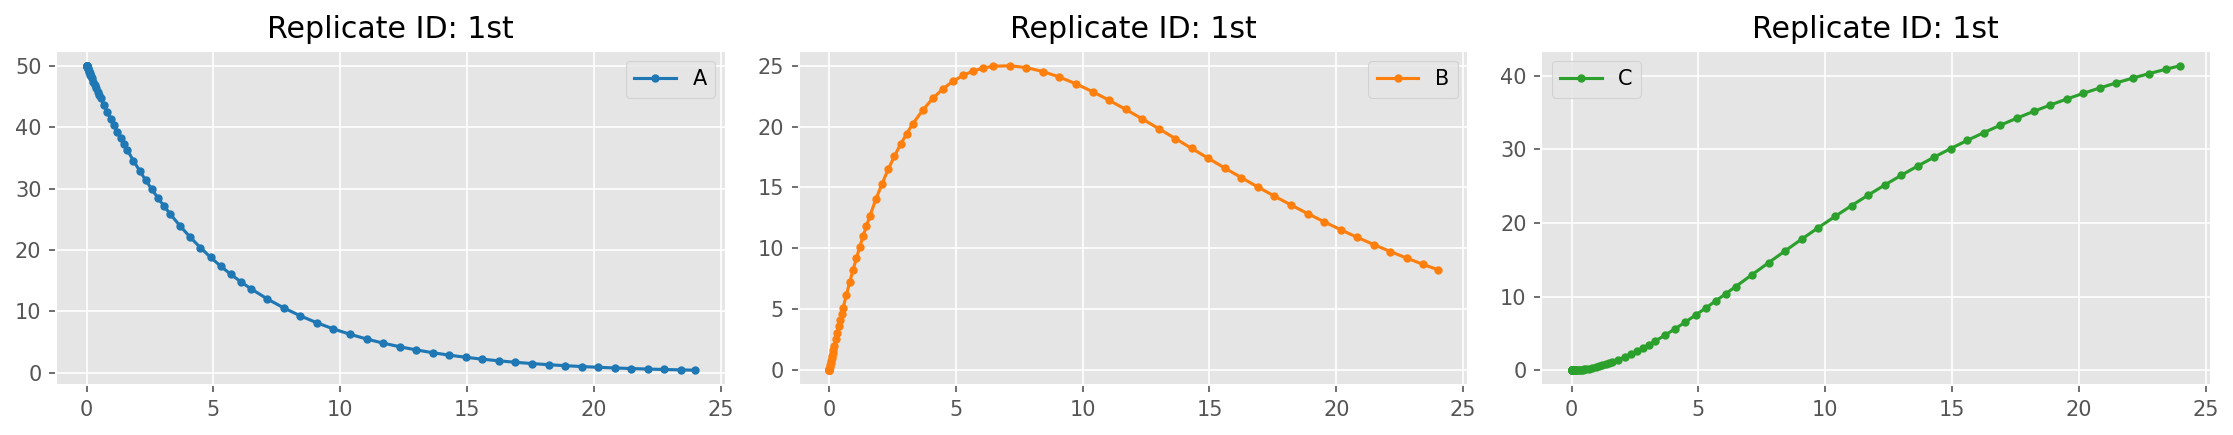

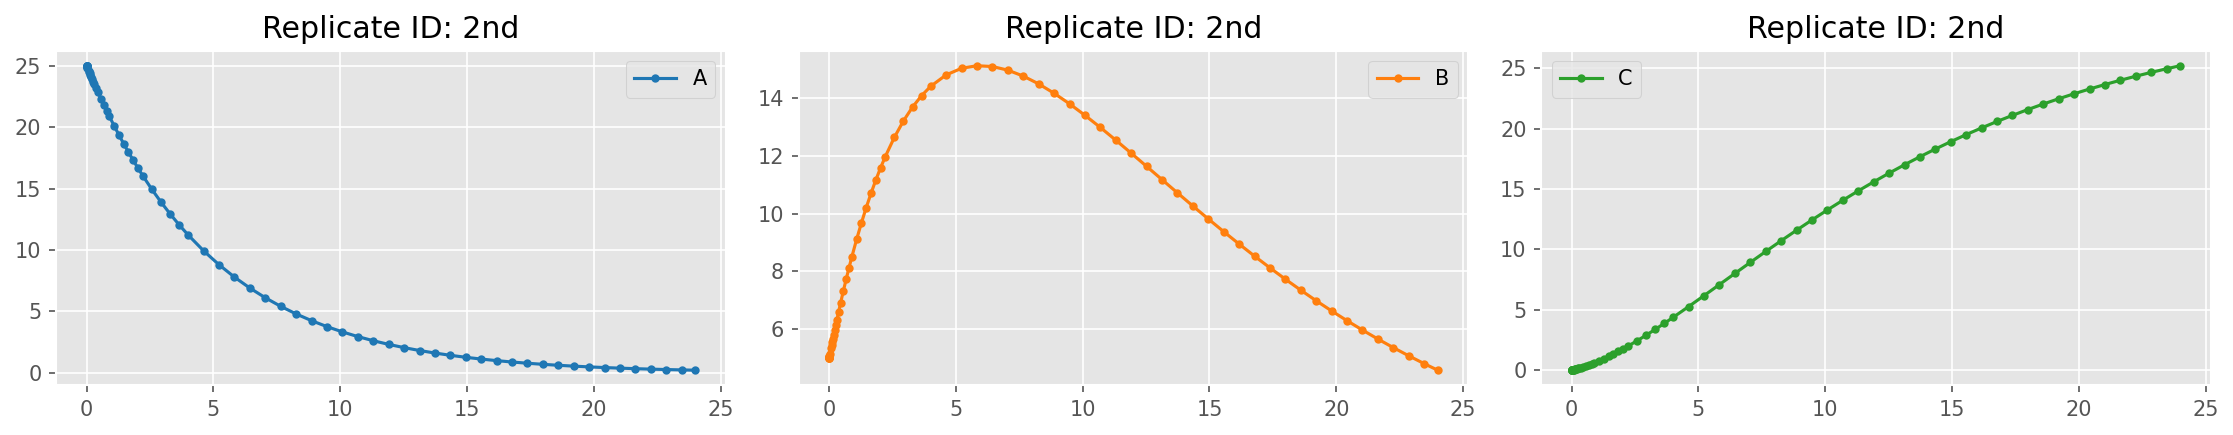

In [12]:
# Runs a forward simulation and visualize the result
simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation)

In [13]:
# Of course, one can add another replicate to the caretaker
caretaker.add_replicate(replicate_id='3rd')

# The new replicate will be assigned the default parameter names and values
caretaker.parameter_mapping

c:\users\hemmerich\source\repos\pyfoomb\pyfoomb\parameter.py:164: UserWarning: Detected unknown parameters, which are ignored: {'A0_1st', 'B0_second', 'A0_2nd'}
  warnings.warn(f'Detected unknown parameters, which are ignored: {unknown_parameters}', UserWarning)


local_name value
global_name replicate_id                 
A0          1st              A0_1st  50.0
            2nd              A0_2nd  25.0
            3rd                  A0  50.0
B0          1st                  B0   0.0
            2nd           B0_second   5.0
            3rd                  B0   0.0
C0          1st                  C0   0.0
            2nd                  C0   0.0
            3rd                  C0   0.0
k1          1st                  k1   0.2
            2nd                  k1   0.2
            3rd                  k1   0.2
k2          1st                  k2   0.1
            2nd                  k2   0.1
            3rd                  k2   0.1

In [14]:
# Now modify a model parameter for the newly added replicate
# NOTE: The mappings bust be list of ParameterMapper objects
# NOTE: When the `value` argument is not set, the value of the global parameter is used.
mappings = [ParameterMapper(replicate_id='3rd', global_name='k1')]
caretaker.apply_mappings(mappings)
caretaker.parameter_mapping

local_name value
global_name replicate_id                 
A0          1st              A0_1st  50.0
            2nd              A0_2nd  25.0
            3rd                  A0  50.0
B0          1st                  B0   0.0
            2nd           B0_second   5.0
            3rd                  B0   0.0
C0          1st                  C0   0.0
            2nd                  C0   0.0
            3rd                  C0   0.0
k1          1st                  k1   0.2
            2nd                  k1   0.2
            3rd              k1_3rd   0.2
k2          1st                  k2   0.1
            2nd                  k2   0.1
            3rd                  k2   0.1

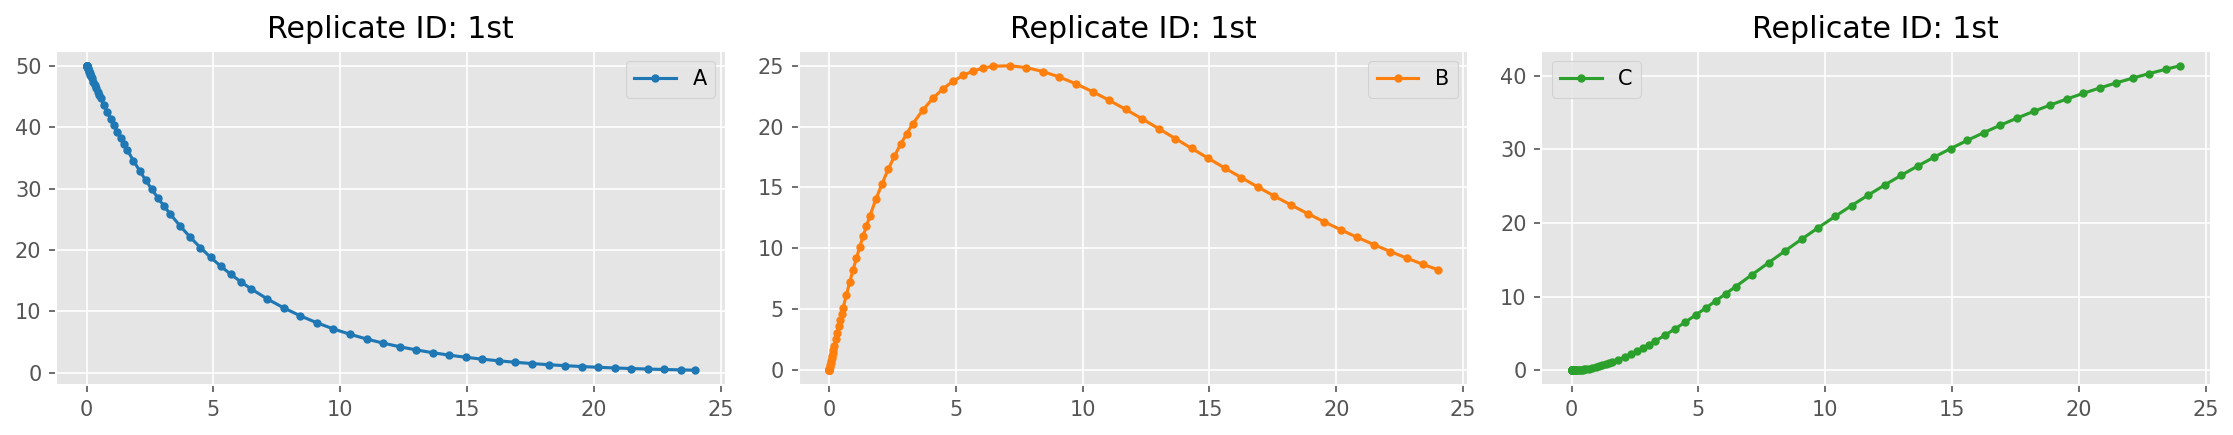

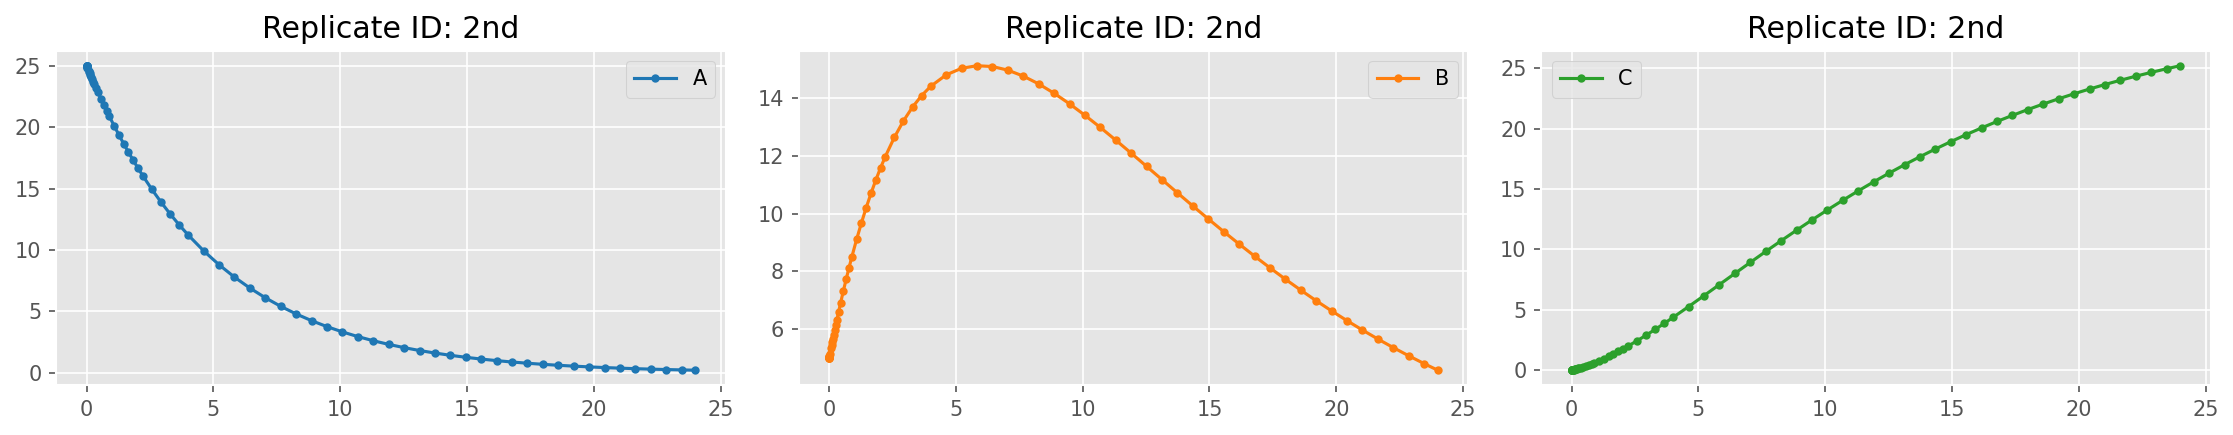

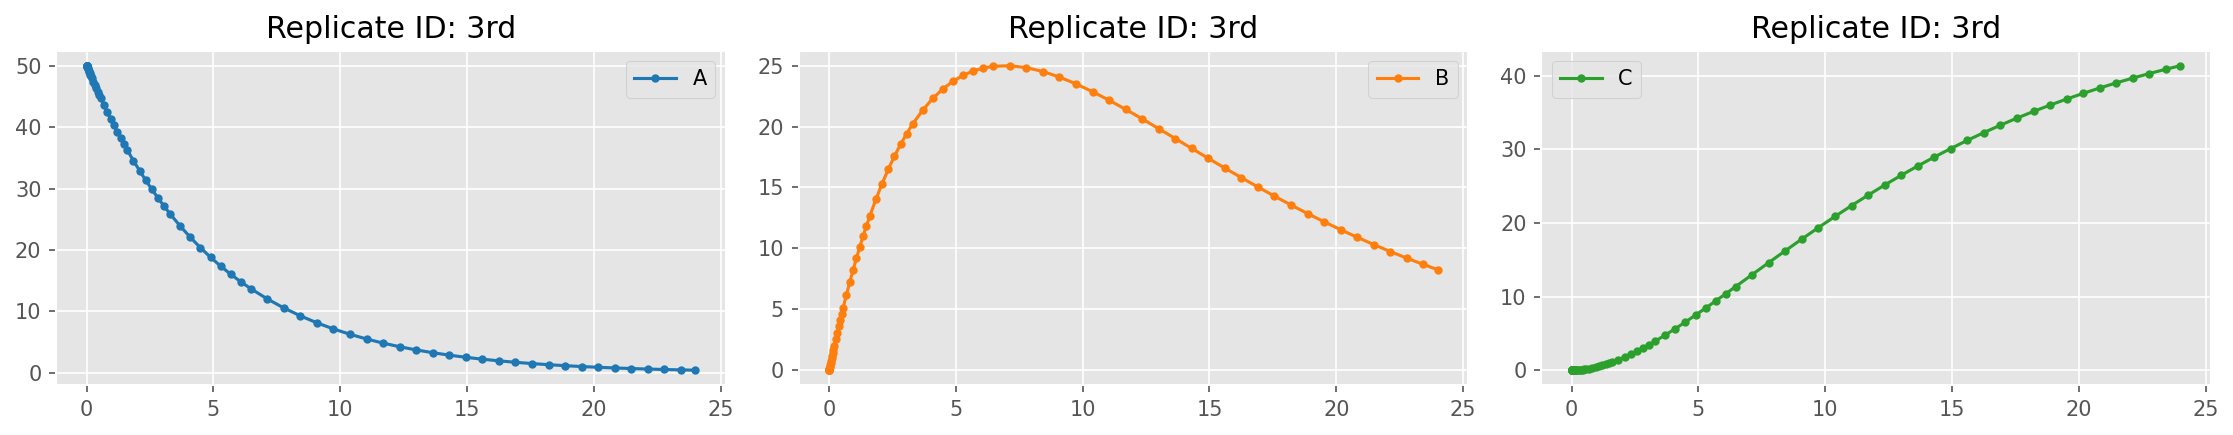

In [15]:
simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation)